# Import unwrap

In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install --no-deps -U --no-cache git+https://github.com/jgraving/unwrap
!{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install fastprogress
# !{sys.executable} -m pip install nutpie

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-8y9c1cpz
  Resolved https://github.com/jgraving/unwrap to commit 48e371b3a1a5af14f3f2e8fd0abe0b5c451be9bd
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13551 sha256=ae6a09cbd90072feab6b7f8805a7069bfa1a3a3fc1756a2f4f3771d0628811bd
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-_o5tlb3f\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-8y9c1cpz'


Defaulting to user installation because normal site-packages is not writeable


# Read in data

In [2]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'SecurityLightBergsig.txt'
df = pd.read_csv(file_path, sep='\t')

# Create a binary indicator for the Light (1 for 'ON', 0 for 'OFF')
df['Light'] = df['Experiment'].apply(lambda x: 1 if 'ON' in x else 0)

# Convert the 'Heading' column from degrees to radians
df['Heading'] = pd.to_numeric(df['Heading'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN
df['HeadingRadians'] = np.deg2rad(df['Heading'])

# Normalize the heading radians to be between -pi and pi
df['HeadingRadians'] = df['HeadingRadians'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['Light', 'Beetle', 'Trial', 'HeadingRadians']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'Beetle': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()


Light Individual  Trial  HeadingRadians
0      1          1      1        2.617994
1      1          1      2       -2.792527
2      1          1      3       -2.792527
3      1          1      4       -2.617994
4      1          1      5       -2.617994

# Plot data

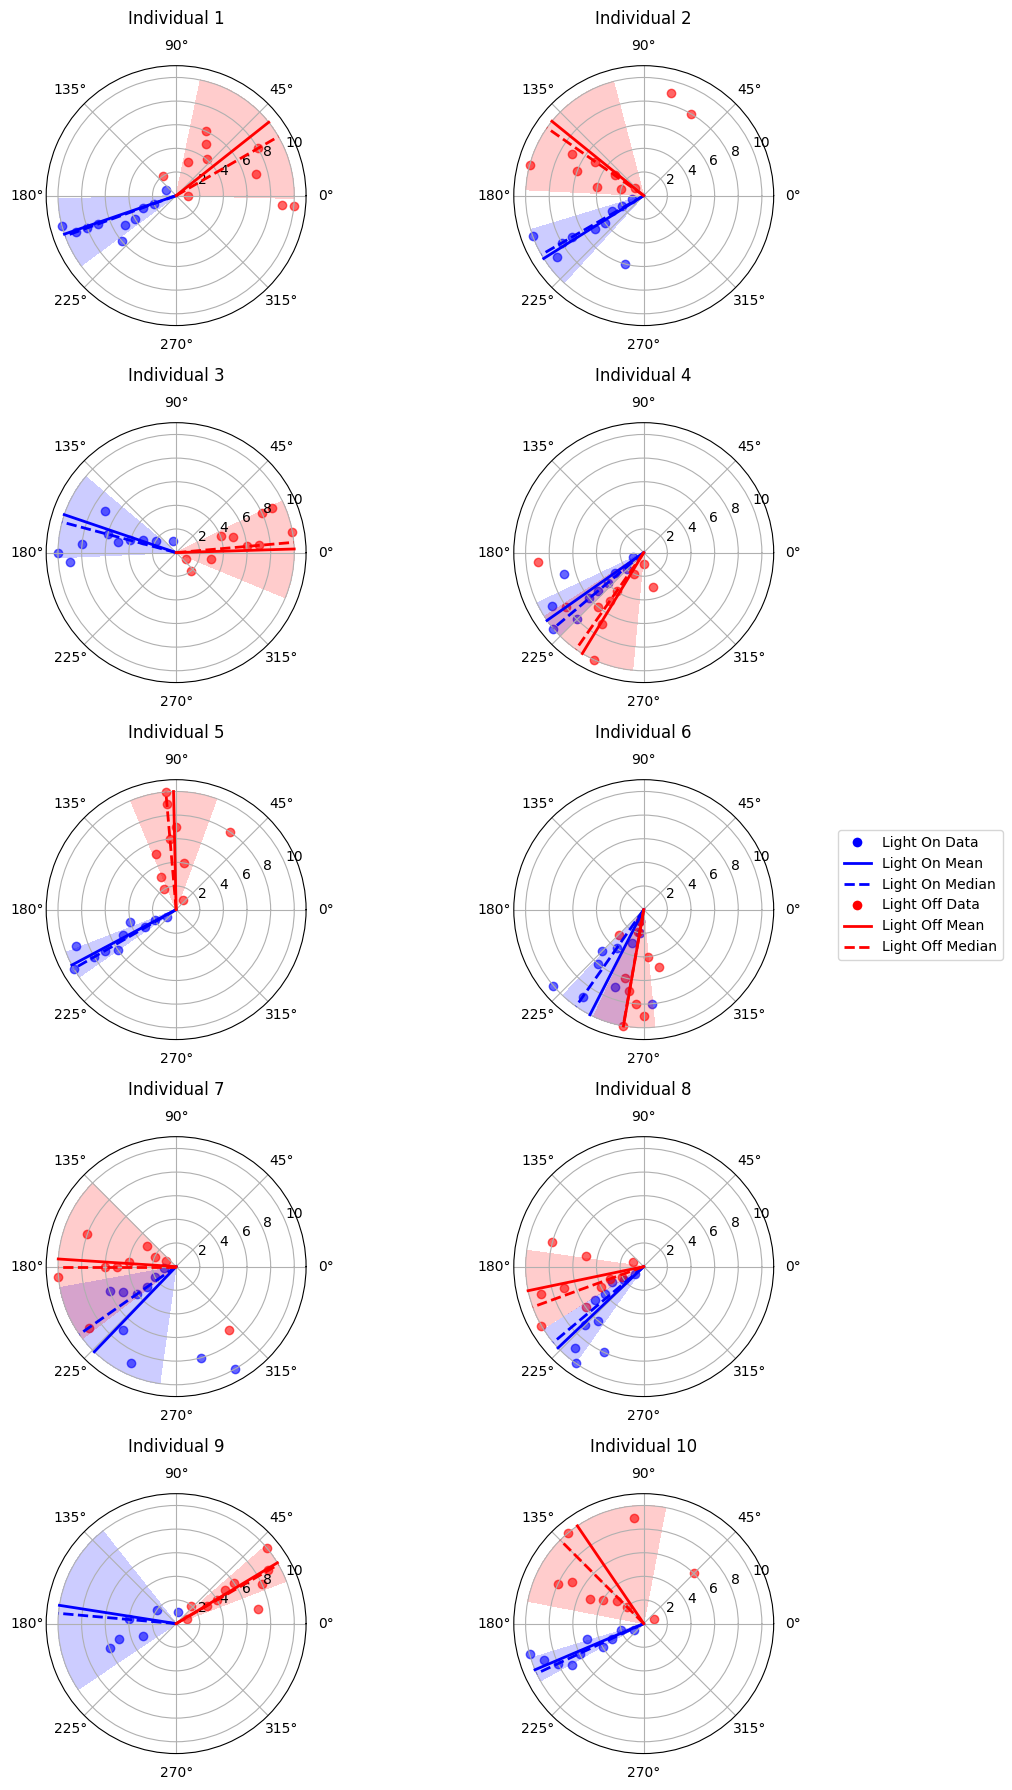

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light On and Light Off data (drop NaNs in HeadingRadians).
    data_on = individual_data[individual_data['Light'] == 1].dropna(subset=['HeadingRadians'])
    data_off = individual_data[individual_data['Light'] == 0].dropna(subset=['HeadingRadians'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'HeadingRadians', 'Trial', 'blue', 'Light On')
    plot_scatter(ax, data_off, 'HeadingRadians', 'Trial', 'red', 'Light Off')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['HeadingRadians'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['HeadingRadians'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light On Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light On Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light On Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Off Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Off Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Off Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()


# Initial model

In [4]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "Light|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_tight = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_tight)

# Fit the model.
idata_tight = model_tight.fit(tune = 1000, draws=1000, idata_kwargs={"log_likelihood": True})


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_sigma, Light|Individual_offset, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


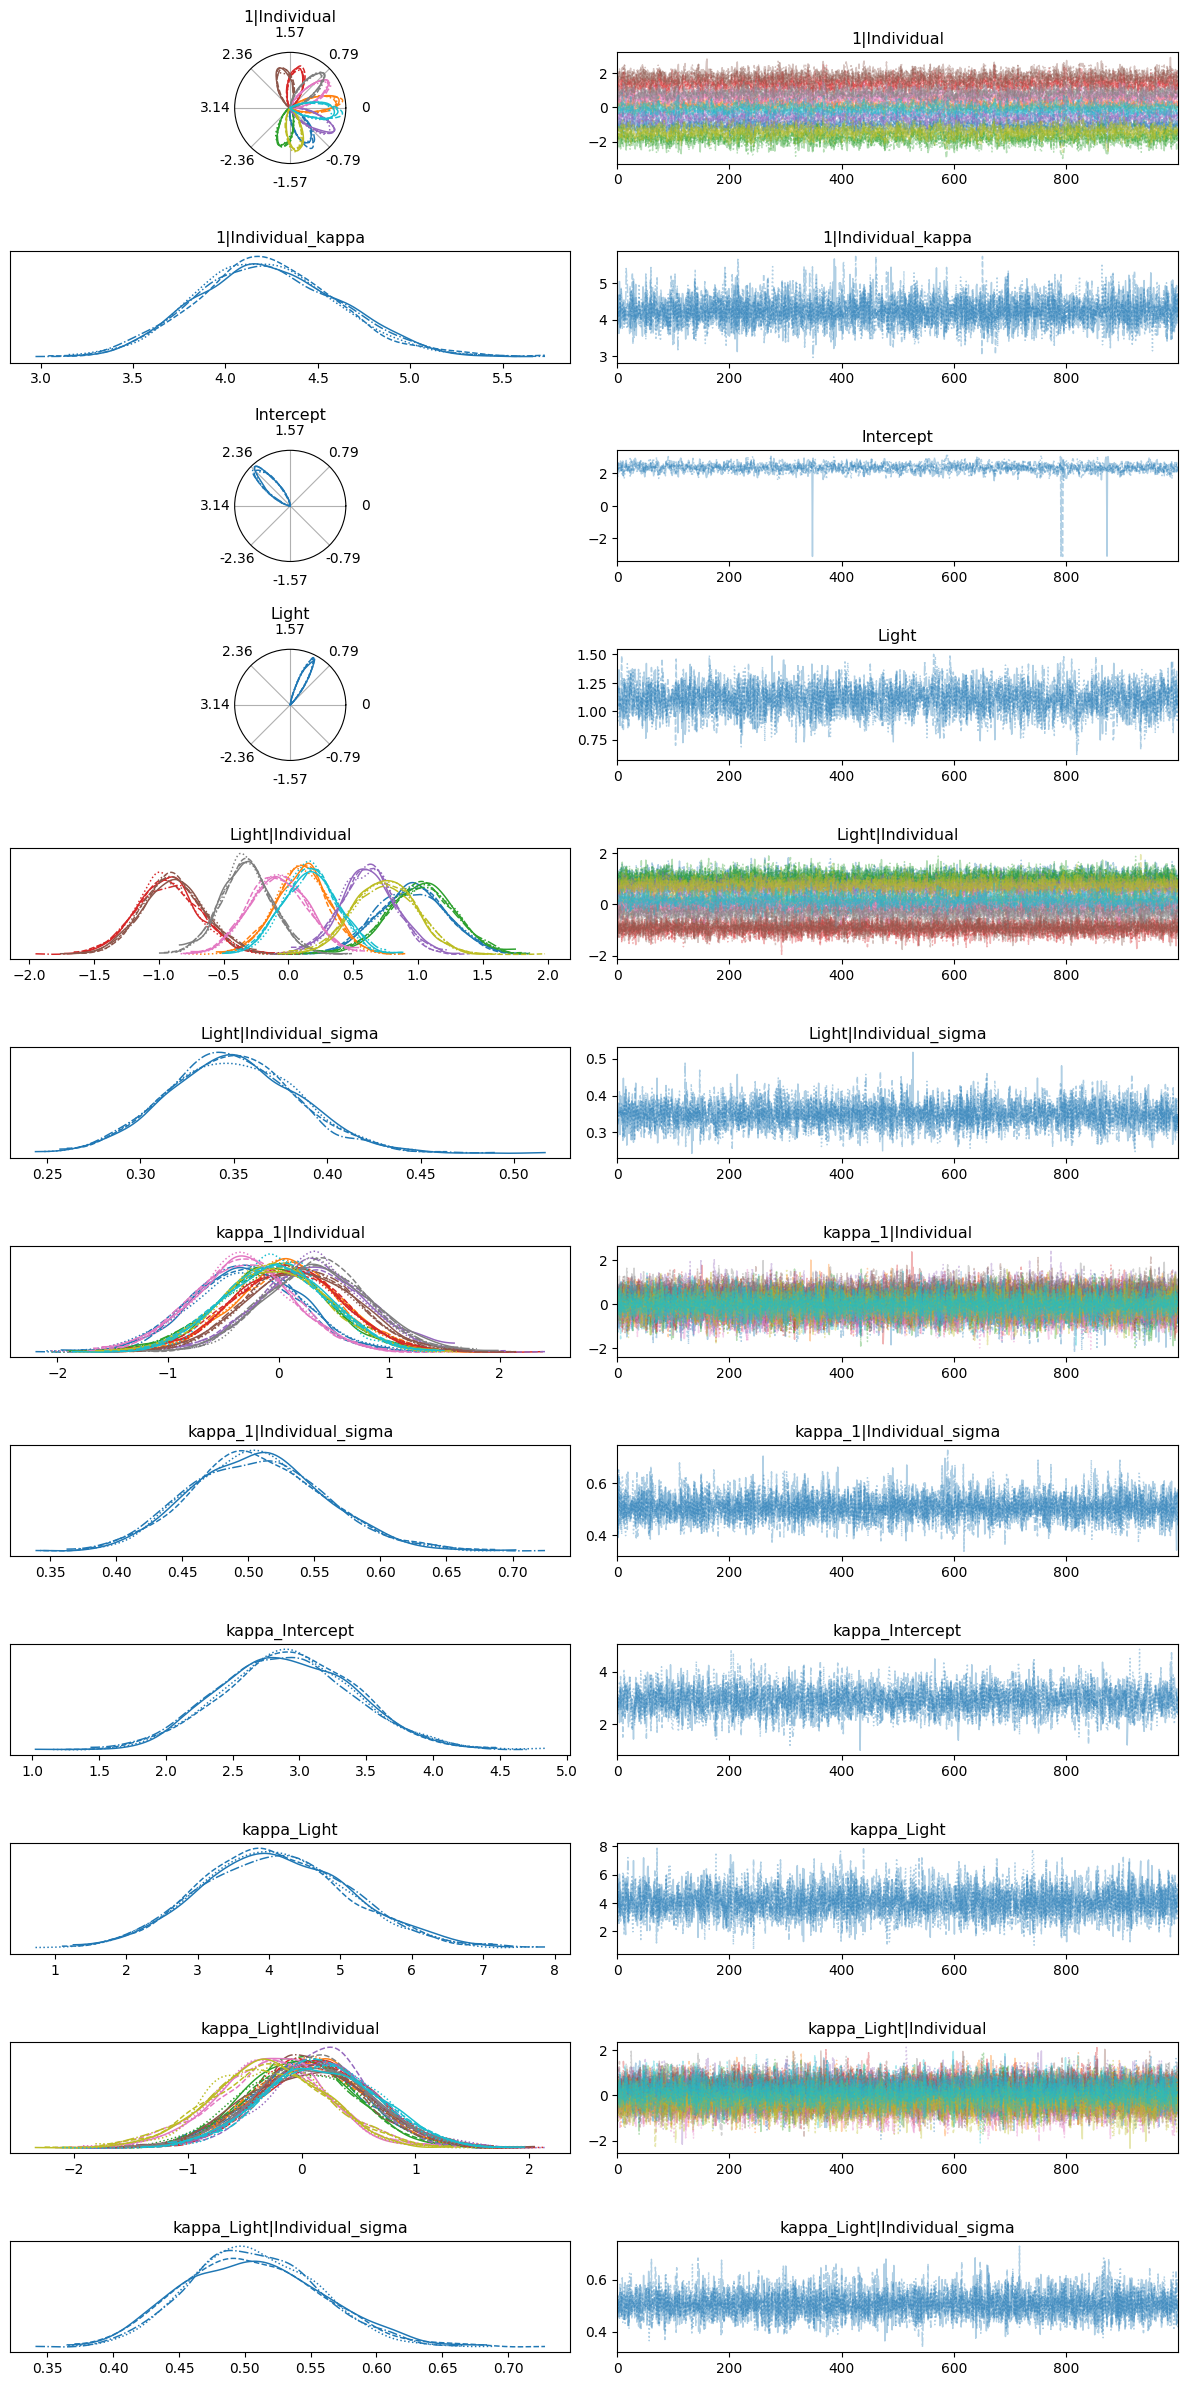

In [5]:
az.plot_trace(idata_tight, circ_var_names=["Light", "Intercept", "1|Individual"])
plt.tight_layout()
plt.show()

In [6]:
az.summary(
    idata_tight, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        2.339  0.238   1.889    2.796      0.007    0.040    1401.0   
Light            1.107  0.128   0.863    1.341      0.002    0.002    3414.0   
kappa_Intercept  2.914  0.503   1.996    3.867      0.009    0.006    3270.0   
kappa_Light      4.095  1.059   2.148    6.140      0.014    0.017    5583.0   

                 ess_tail  r_hat  
Intercept          1946.0    1.0  
Light              3384.0    1.0  
kappa_Intercept    3484.0    1.0  
kappa_Light        3104.0    1.0

In [7]:
az.summary(
    idata_tight, 
    circ_var_names=["Intercept", "Light", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|Individual[1]              -1.052  0.315  -1.663   -0.487      0.008   
1|Individual[2]               0.137  0.265  -0.363    0.646      0.006   
1|Individual[3]              -1.787  0.335  -2.400   -1.137      0.009   
1|Individual[4]               1.354  0.318   0.802    1.987      0.009   
1|Individual[5]              -0.502  0.268  -0.986    0.036      0.008   
1|Individual[6]               1.793  0.318   1.230    2.419      0.009   
1|Individual[7]               0.589  0.278   0.094    1.139      0.007   
1|Individual[8]               0.817  0.275   0.308    1.334      0.008   
1|Individual[9]              -1.414  0.300  -1.940   -0.812      0.009   
1|Individual[10]             -0.090  0.269  -0.610    0.404      0.005   
1|Individual_kappa            4.235  0.390   3.514    4.964      0.005   
Intercept                     2.339  0.238   1.889    2.796      0.007   
Light                         1.107  0.128   0.863    1.341      0.002   
Light|Individual[1]           0.956  0.267   0.469    1.458      0.004   
Light|Individual[2]           0.107  0.207  -0.274    0.505      0.003   
Light|Individual[3]           1.020  0.264   0.536    1.527      0.004   
Light|Individual[4]          -0.932  0.247  -1.370   -0.444      0.004   
Light|Individual[5]           0.614  0.211   0.212    1.011      0.003   
Light|Individual[6]          -0.890  0.237  -1.345   -0.457      0.003   
Light|Individual[7]          -0.078  0.224  -0.510    0.320      0.003   
Light|Individual[8]          -0.323  0.199  -0.701    0.060      0.003   
Light|Individual[9]           0.742  0.241   0.301    1.186      0.003   
Light|Individual[10]          0.167  0.210  -0.230    0.557      0.003   
Light|Individual_sigma        0.349  0.034   0.282    0.412      0.001   
kappa_1|Individual[1]        -0.299  0.492  -1.237    0.603      0.005   
kappa_1|Individual[2]         0.087  0.477  -0.765    1.029      0.006   
kappa_1|Individual[3]        -0.048  0.507  -0.981    0.950      0.007   
kappa_1|Individual[4]         0.074  0.502  -0.837    1.055      0.006   
kappa_1|Individual[5]         0.317  0.483  -0.576    1.248      0.005   
kappa_1|Individual[6]         0.197  0.494  -0.703    1.142      0.006   
kappa_1|Individual[7]        -0.327  0.459  -1.207    0.547      0.005   
kappa_1|Individual[8]         0.342  0.471  -0.504    1.255      0.005   
kappa_1|Individual[9]        -0.040  0.484  -0.969    0.855      0.005   
kappa_1|Individual[10]       -0.024  0.463  -0.898    0.822      0.005   
kappa_1|Individual_sigma      0.507  0.051   0.415    0.603      0.001   
kappa_Intercept               2.914  0.503   1.996    3.867      0.009   
kappa_Light                   4.095  1.059   2.148    6.140      0.014   
kappa_Light|Individual[1]     0.053  0.509  -0.998    0.924      0.005   
kappa_Light|Individual[2]     0.081  0.503  -0.825    1.025      0.005   
kappa_Light|Individual[3]    -0.011  0.494  -0.925    0.907      0.005   
kappa_Light|Individual[4]     0.124  0.493  -0.783    1.070      0.005   
kappa_Light|Individual[5]     0.140  0.505  -0.838    1.086      0.006   
kappa_Light|Individual[6]     0.056  0.519  -0.953    0.987      0.005   
kappa_Light|Individual[7]    -0.271  0.501  -1.212    0.706      0.006   
kappa_Light|Individual[8]     0.114  0.514  -0.911    1.031      0.006   
kappa_Light|Individual[9]    -0.293  0.517  -1.241    0.713      0.005   
kappa_Light|Individual[10]    0.167  0.501  -0.738    1.140      0.005   
kappa_Light|Individual_sigma  0.506  0.051   0.412    0.600      0.001   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
1|Individual[1]                 0.005    2028.0    2335.0    1.0  
1|Individual[2]                 0.004    1703.0    2143.0    1.0  
1|Individual[3]                 0.005    1772.0    2105.0    1.0  
1|Individual[4]                 0.005    1957.0    2373.0    1.0  
1|Individual[5]                 0.004    1817.0    2107.0    1.0  
1|

## Plot intitial model

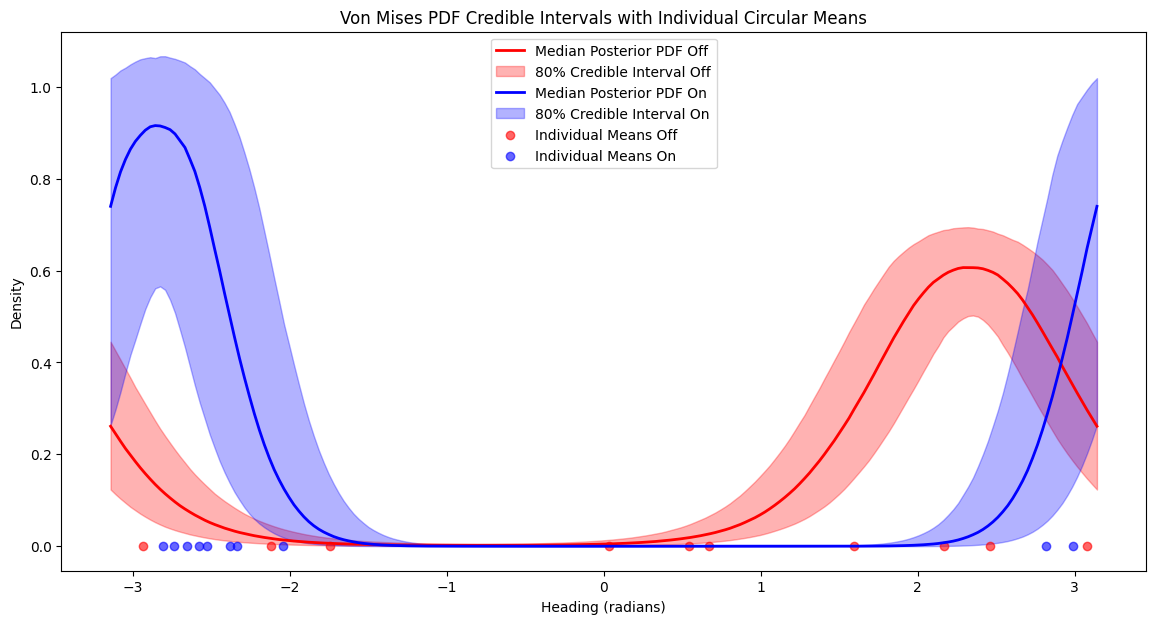

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_tight.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_tight.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_tight.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_tight.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_off = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_off_samples_all[:, None],
    loc=mu_pop_off_samples_all[:, None]
)
pdf_on = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_on_samples_all[:, None],
    loc=mu_pop_on_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval.
median_pdf_off = np.median(pdf_off, axis=0)
lower_pdf_off  = np.percentile(pdf_off, 10, axis=0)
upper_pdf_off  = np.percentile(pdf_off, 90, axis=0)

median_pdf_on = np.median(pdf_on, axis=0)
lower_pdf_on  = np.percentile(pdf_on, 10, axis=0)
upper_pdf_on  = np.percentile(pdf_on, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_off, color='red', lw=2, label='Median Posterior PDF Off')
ax.fill_between(theta, lower_pdf_off, upper_pdf_off, color='red', alpha=0.3,
                label='80% Credible Interval Off')

ax.plot(theta, median_pdf_on, color='blue', lw=2, label='Median Posterior PDF On')
ax.fill_between(theta, lower_pdf_on, upper_pdf_on, color='blue', alpha=0.3,
                label='80% Credible Interval On')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_off, 0, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax.scatter(individual_circmean_on, 0, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()


## Plot population-level predictions

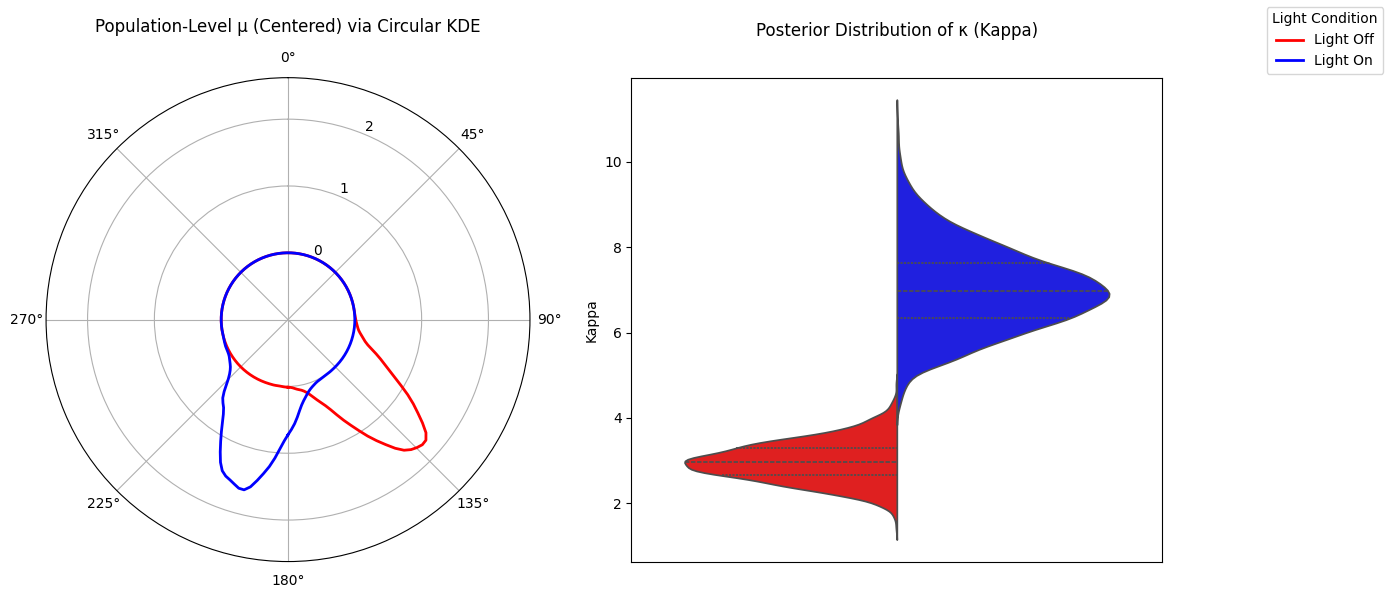

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')
ax1.set_title("Population-Level μ (Centered) via Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])
# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 2, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for Both Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()


# Model with larger treatment effect on hyperparameters
Here we wider the priors on hyperparameters, putting a strong positive bias on the $\kappa_\mu$ hyperparameters since by default we expect strong agreement (partial pooling) for estimates across individuals.

In [10]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_wide = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_wide= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    # "Intercept": bmb.Prior("Normal", mu=0, sigma= 1.0 * np.pi),
    # "Light": bmb.Prior("Normal", mu=0, sigma= 0.75 * np.pi),#wider
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#von Mises
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251021 proposed shrinkage prior
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(10), sigma=0.6) # 20251023 still divergences, try even lower value?
    ),
    "Light|Individual": bmb.Prior(
        # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # my assumed potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=1.5),#wider possible range
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=1.5),#slightly wider
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.5)#slightly wider
            # "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.3)#slightly wider
            # "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_wide = bmb.Model(
    formula_wide,
    df,
    family="vonmises",
    priors=priors_wide,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_wide)

# Fit the model.
idata_wide = model_wide.fit(tune = 1000, draws=1000,
                            # inference_method="nutpie",#faster
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.97  # Needs sampling with small steps
        }
    })


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 2.3026, sigma: 0.6))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.9489, sigma: 1.5)
            kappa_Light ~ Normal(mu: 0.0, sigma: 1.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.3))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 118 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


## Inspect summary


In [11]:
az.summary(
    idata_wide, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa",
                "kappa_1|Individual_sigma", "kappa_Light|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
Intercept                     2.277  0.605   1.070   -2.869      0.033   
Light                         1.322  0.288   0.804    1.898      0.009   
kappa_Intercept               4.295  0.590   3.224    5.429      0.009   
kappa_Light                   2.585  0.891   0.840    4.164      0.012   
1|Individual_kappa            1.477  0.412   0.771    2.276      0.006   
Light|Individual_kappa        2.701  0.731   1.458    4.105      0.009   
kappa_1|Individual_sigma      0.799  0.420   0.160    1.588      0.008   
kappa_Light|Individual_sigma  0.564  0.184   0.272    0.922      0.002   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
Intercept                       0.076     855.0    1263.0    1.0  
Light                           0.006    1033.0    1511.0    1.0  
kappa_Intercept                 0.009    4260.0    3227.0    1.0  
kappa_Light                     0.014    5355.0    3177.0    1.0  
1|Individual_kappa              0.008    4891.0    2309.0    1.0  
Light|Individual_kappa          0.013    6167.0    2687.0    1.0  
kappa_1|Individual_sigma        0.007    2777.0    3224.0    1.0  
kappa_Light|Individual_sigma    0.004    6755.0    3027.0    1.0

In [12]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual", "kappa_Light|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]            -1.478  0.635  -2.760   -0.300      0.032    0.038   
1|Individual[2]             0.176  0.604  -0.968    1.360      0.030    0.018   
1|Individual[3]            -2.153  0.637   2.851   -0.981      0.033    0.070   
1|Individual[4]             1.795  0.629   0.504    2.933      0.034    0.060   
1|Individual[5]            -0.630  0.609  -1.806    0.546      0.034    0.019   
1|Individual[6]             2.184  0.631   0.925   -2.924      0.035    0.073   
1|Individual[7]             0.726  0.621  -0.486    1.903      0.032    0.019   
1|Individual[8]             1.009  0.617  -0.184    2.186      0.034    0.021   
1|Individual[9]            -1.651  0.623  -2.908   -0.502      0.033    0.046   
1|Individual[10]           -0.099  0.610  -1.411    0.940      0.034    0.018   
Light|Individual[1]         1.310  0.364   0.650    2.007      0.009    0.006   
Light|Individual[2]        -0.070  0.332  -0.685    0.580      0.010    0.006   
Light|Individual[3]         1.328  0.355   0.697    2.030      0.010    0.006   
Light|Individual[4]        -1.608  0.352  -2.250   -0.925      0.010    0.006   
Light|Individual[5]         0.639  0.323   0.070    1.291      0.008    0.005   
Light|Individual[6]        -1.507  0.347  -2.177   -0.856      0.008    0.005   
Light|Individual[7]        -0.366  0.345  -0.978    0.337      0.010    0.006   
Light|Individual[8]        -0.687  0.328  -1.296   -0.058      0.009    0.006   
Light|Individual[9]         0.962  0.355   0.309    1.656      0.008    0.006   
Light|Individual[10]        0.041  0.330  -0.611    0.653      0.008    0.005   
kappa_1|Individual[1]      -0.365  0.760  -1.868    1.048      0.012    0.012   
kappa_1|Individual[2]      -0.145  0.714  -1.621    1.140      0.010    0.014   
kappa_1|Individual[3]       0.157  0.756  -1.225    1.728      0.011    0.015   
kappa_1|Individual[4]       0.368  0.811  -0.997    2.066      0.012    0.016   
kappa_1|Individual[5]       0.625  0.918  -0.896    2.400      0.014    0.019   
kappa_1|Individual[6]       0.608  0.930  -0.946    2.405      0.015    0.020   
kappa_1|Individual[7]      -0.926  0.863  -2.640    0.417      0.015    0.013   
kappa_1|Individual[8]       0.577  0.929  -0.996    2.430      0.015    0.021   
kappa_1|Individual[9]      -0.044  0.733  -1.405    1.480      0.010    0.014   
kappa_1|Individual[10]     -0.383  0.756  -1.856    1.036      0.012    0.013   
kappa_Light|Individual[1]   0.092  0.574  -1.028    1.128      0.007    0.012   
kappa_Light|Individual[2]   0.123  0.568  -0.889    1.249      0.007    0.012   
kappa_Light|Individual[3]   0.016  0.595  -1.118    1.128      0.007    0.011   
kappa_Light|Individual[4]   0.175  0.593  -0.973    1.237      0.008    0.013   
kappa_Light|Individual[5]   0.201  0.599  -0.870    1.428      0.008    0.012   
kappa_Light|Individual[6]   0.096  0.611  -1.046    1.336      0.008    0.013   
kappa_Light|Individual[7]  -0.292  0.609  -1.438    0.861      0.009    0.013   
kappa_Light|Individual[8]   0.143  0.588  -0.887    1.331      0.007    0.011   
kappa_Light|Individual[9]  -0.361  0.630  -1.591    0.760      0.008    0.012   
kappa_Light|Individual[10]  0.241  0.622  -0.815    1.497      0.008    0.013   

                            ess_bulk  ess_tail  r_hat  
1|Individual[1]                530.0     759.0   1.01  
1|Individual[2]                484.0     808.0   1.01  
1|Individual[3]                989.0    1095.0   1.00  
1|Individual[4]                793.0     954.0   1.00  
1|Individual[5]                460.0     706.0   1.01  
1|Individual[6]               1038.0    1153.0   1.00  
1|Individual[7]                489.0     800.0   1.01  
1|Individual[8]                481.0     781.0   1.01  
1|Individual[9]                547.0     746.0   1.01  
1|Individual[10]               493.0     774.0   1.01  
Light|Individual[1]           1423.0    1873.0   1.00  
Light|Individual[2]           1298.

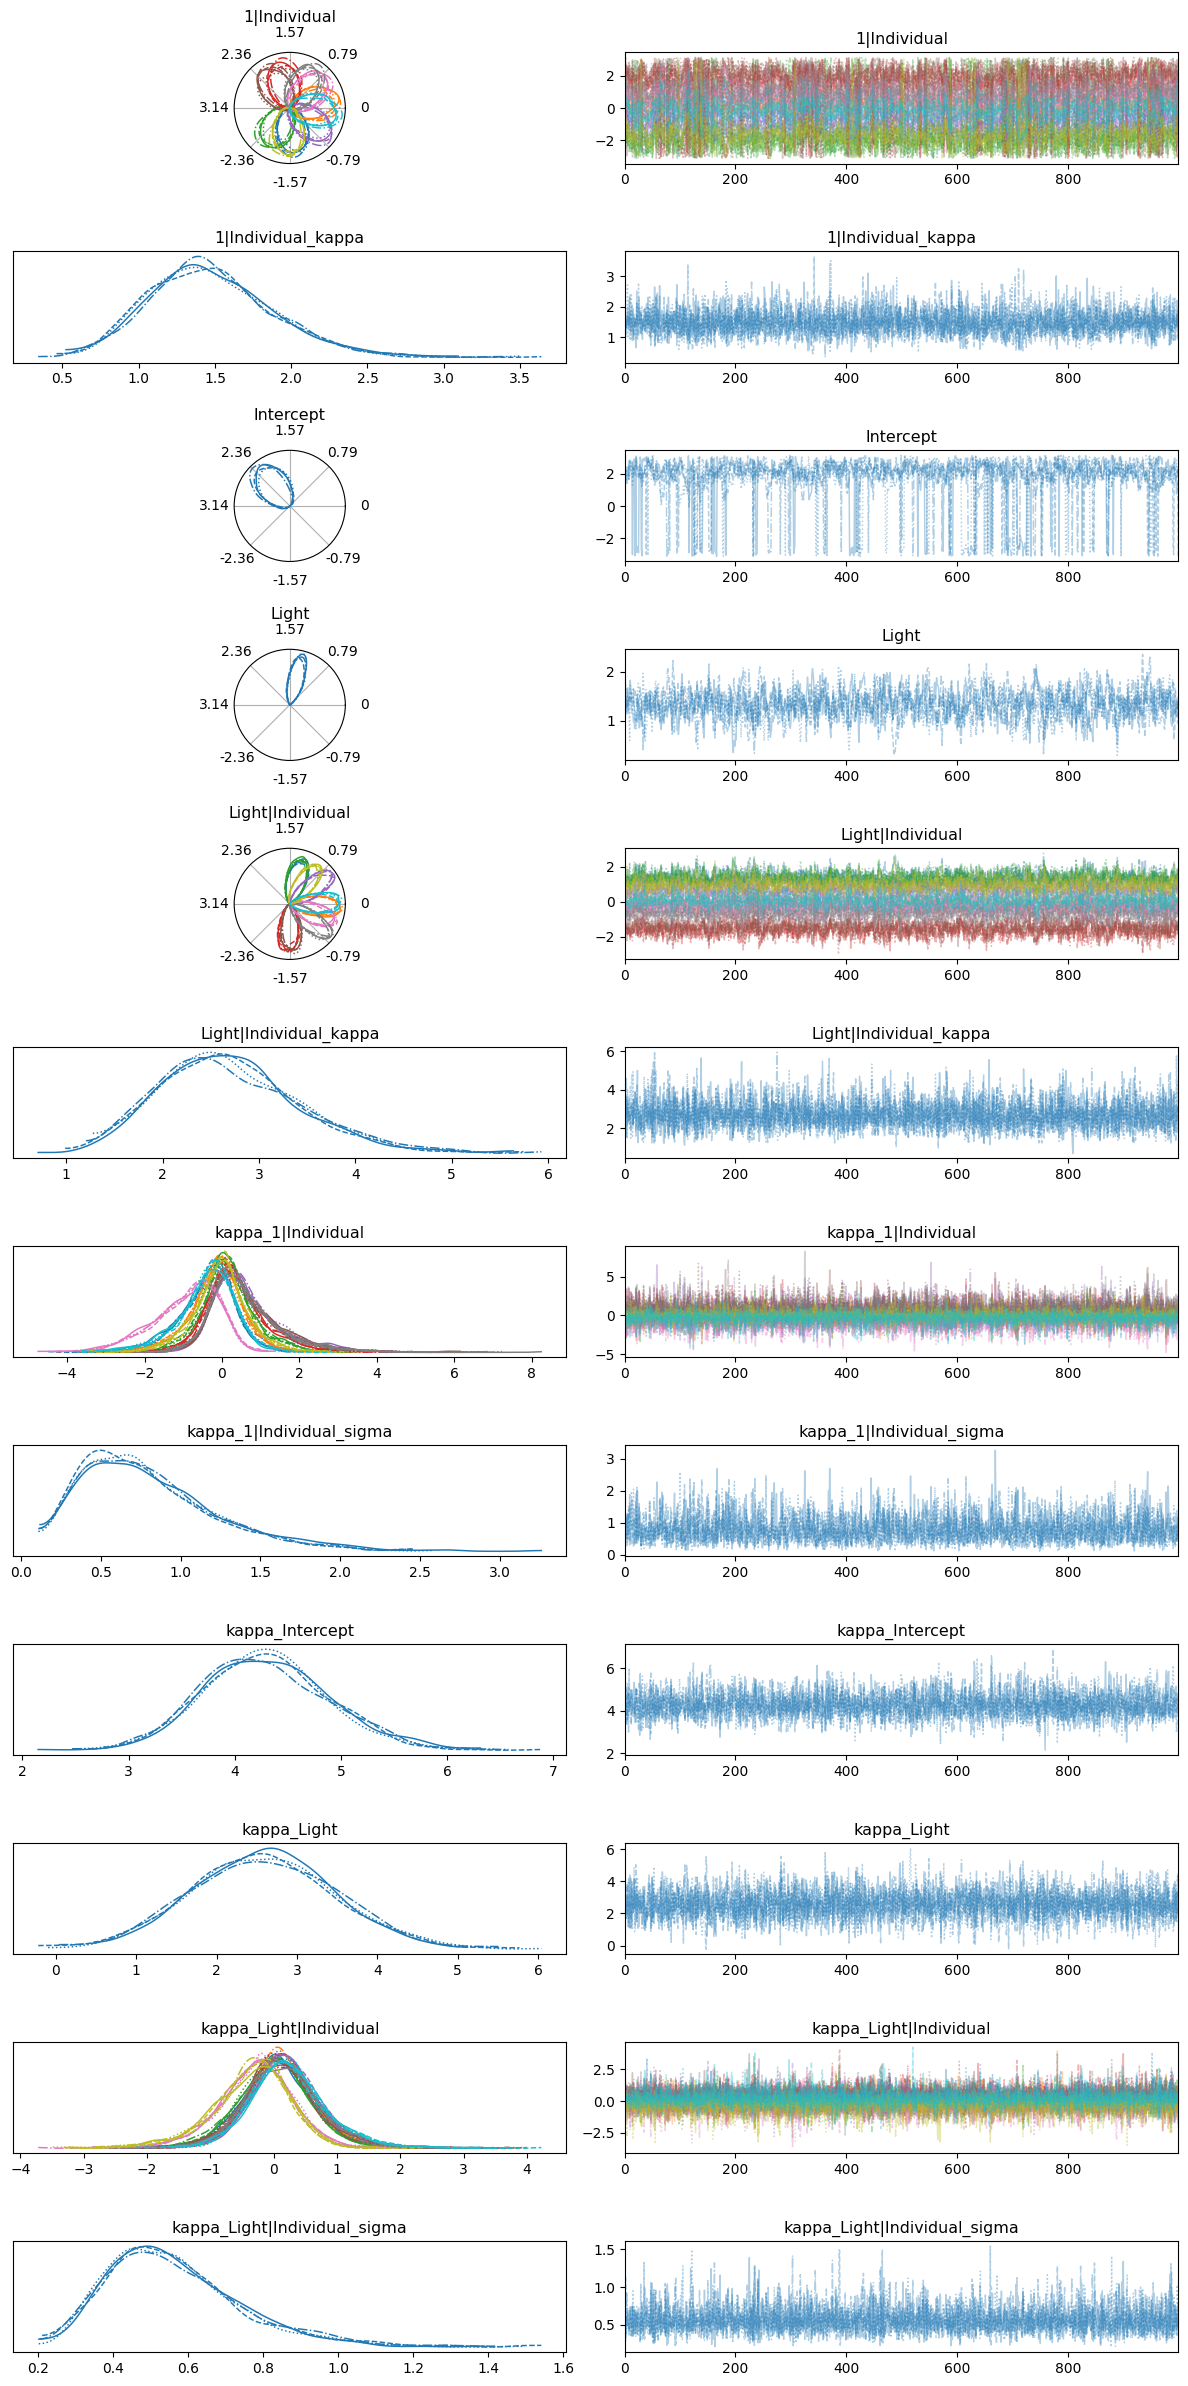

In [13]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
idata_wide_trans = idata_wide.copy() # set up a variable for transformed data
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_wide,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

We can already see here that nearly all estimates of Light|Individual $\kappa$ are above 1.0 (all > 0), which suggests that individual biases became more aligned after switched on. Combined with 1|Individual $\kappa$ and the $\log(\exp(x)+1)$ transform, this would correspond to an increase in $\kappa$ of $\approx 1.3—4.1$.  Note that this effect is separate from the effect of the light on individual accuracy ("$\kappa$ Light"), which was also large and overwhelmingly positive, but needn't necessarily imply greater alignment between individuals.

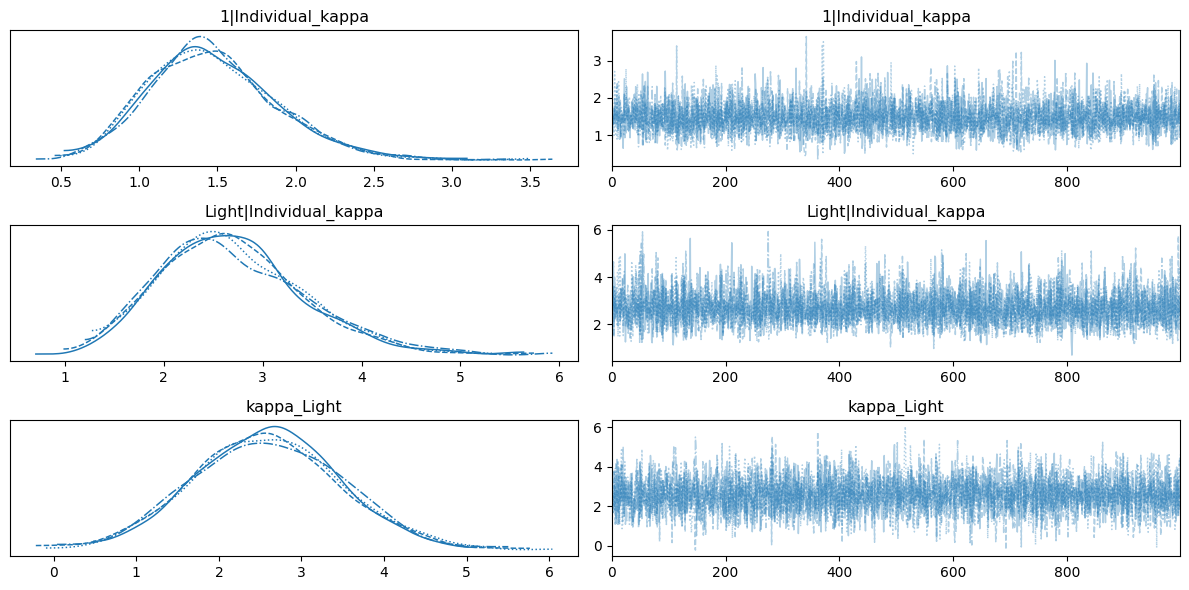

In [ ]:
az.plot_trace(idata_wide,
              var_names=["1|Individual_kappa","Light|Individual_kappa", "kappa_Light"],
              )
plt.tight_layout()
plt.show()

In [ ]:
# For the κ_μ-model:
kappamu_intercept = idata_wide.posterior["1|Individual_kappa"].values    # fixed intercept for κ_μ (linear predictor)
kappamu_slope     = idata_wide.posterior["Light|Individual_kappa"].values        # fixed slope for κ_μ (linear predictor)
kappamu_pop_off_samples_all = softplus(kappamu_intercept.flatten())
kappamu_pop_on_samples_all  = softplus((kappamu_intercept + kappamu_slope).flatten())
#How large is the effect of the light on kappa_mu?
np.quantile(kappamu_pop_on_samples_all - kappamu_pop_off_samples_all, q = [0.025, 0.975])

array([1.33349492, 4.12482056])

# Model no change in $\kappa_\mu$
Our hypothesis is that turning on the light increased the correlation across individual headings. We could test this by excluding the effect of light on the population of individual headings.

In [14]:
# from fastprogress import fastprogress
# fastprogress.printing = lambda: True

import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_nolightkm = bmb.Formula(
    "HeadingRadians ~ Light + (1|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_nolightkm= {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#For this model this parameter is now difficult to estimate (as we would expect), loosening helps?
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(15), sigma=0.3)
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251022 needs to be low to converge?
    ),
    # "Light|Individual": bmb.Prior(
    #     # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    #     "VonMises", mu=0, kappa=100 # the light has almost no effect on individual headings (Mardia SD≈6°)
    # ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(1.0), sigma=3.0),#combined expected to be lower
        # "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        "Light": bmb.Prior("Normal", mu=0, sigma=3.0),#narrower
        # Individual-level effects for κ:
         "1|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.5)#slightly wider
            # "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
        "Light|Individual": bmb.Prior(
            # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.3)#slightly wider
            # "Normal", mu=0, sigma=bmb.Prior("HalfStudentT", nu = 3, sigma=1.0)#much wider
        ),
    },
}

# Build the model using the updated formula and priors.
model_nolightkm = bmb.Model(
    formula_nolightkm,
    df,
    family="vonmises",
    priors=priors_nolightkm,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_nolightkm)

# Fit the model.
idata_nolightkm = model_nolightkm.fit(tune = 1000, draws=1000,
                            idata_kwargs={"log_likelihood": True},
                            sample_kwargs={
        "tune_kwargs": {
            "target_accept": 0.99  # take small steps to avoid divergences
        }
    })


       Formula: HeadingRadians ~ Light + (1|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 2.7081, sigma: 0.3))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 0.5413, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 3.0)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.5))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.3))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [15]:
az.summary(
    idata_nolightkm, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa",
                "kappa_1|Individual_sigma"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept                  2.336  0.589   1.352   -2.791      0.022    0.085   
Light                      1.271  0.573   0.193    2.256      0.022    0.013   
kappa_Intercept            0.384  0.739  -1.013    1.688      0.022    0.029   
kappa_Light                7.265  1.207   5.064    9.463      0.029    0.027   
1|Individual_kappa        10.950  2.744   6.340   16.103      0.051    0.050   
kappa_1|Individual_sigma   1.646  0.664   0.525    2.858      0.023    0.017   

                          ess_bulk  ess_tail  r_hat  
Intercept                   1042.0    1709.0   1.00  
Light                        336.0     611.0   1.01  
kappa_Intercept             1403.0    1074.0   1.00  
kappa_Light                 1889.0    1609.0   1.00  
1|Individual_kappa          2864.0    2934.0   1.00  
kappa_1|Individual_sigma     907.0    1252.0   1.00

In [16]:
az.summary(
    idata_wide, 
    var_names=["1|Individual", "Light|Individual",
                "kappa_1|Individual"],
    circ_var_names=["1|Individual", "Light|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
1|Individual[1]        -1.478  0.635  -2.760   -0.300      0.032    0.038   
1|Individual[2]         0.176  0.604  -0.968    1.360      0.030    0.018   
1|Individual[3]        -2.153  0.637   2.851   -0.981      0.033    0.070   
1|Individual[4]         1.795  0.629   0.504    2.933      0.034    0.060   
1|Individual[5]        -0.630  0.609  -1.806    0.546      0.034    0.019   
1|Individual[6]         2.184  0.631   0.925   -2.924      0.035    0.073   
1|Individual[7]         0.726  0.621  -0.486    1.903      0.032    0.019   
1|Individual[8]         1.009  0.617  -0.184    2.186      0.034    0.021   
1|Individual[9]        -1.651  0.623  -2.908   -0.502      0.033    0.046   
1|Individual[10]       -0.099  0.610  -1.411    0.940      0.034    0.018   
Light|Individual[1]     1.310  0.364   0.650    2.007      0.009    0.006   
Light|Individual[2]    -0.070  0.332  -0.685    0.580      0.010    0.006   
Light|Individual[3]     1.328  0.355   0.697    2.030      0.010    0.006   
Light|Individual[4]    -1.608  0.352  -2.250   -0.925      0.010    0.006   
Light|Individual[5]     0.639  0.323   0.070    1.291      0.008    0.005   
Light|Individual[6]    -1.507  0.347  -2.177   -0.856      0.008    0.005   
Light|Individual[7]    -0.366  0.345  -0.978    0.337      0.010    0.006   
Light|Individual[8]    -0.687  0.328  -1.296   -0.058      0.009    0.006   
Light|Individual[9]     0.962  0.355   0.309    1.656      0.008    0.006   
Light|Individual[10]    0.041  0.330  -0.611    0.653      0.008    0.005   
kappa_1|Individual[1]  -0.365  0.760  -1.868    1.048      0.012    0.012   
kappa_1|Individual[2]  -0.145  0.714  -1.621    1.140      0.010    0.014   
kappa_1|Individual[3]   0.157  0.756  -1.225    1.728      0.011    0.015   
kappa_1|Individual[4]   0.368  0.811  -0.997    2.066      0.012    0.016   
kappa_1|Individual[5]   0.625  0.918  -0.896    2.400      0.014    0.019   
kappa_1|Individual[6]   0.608  0.930  -0.946    2.405      0.015    0.020   
kappa_1|Individual[7]  -0.926  0.863  -2.640    0.417      0.015    0.013   
kappa_1|Individual[8]   0.577  0.929  -0.996    2.430      0.015    0.021   
kappa_1|Individual[9]  -0.044  0.733  -1.405    1.480      0.010    0.014   
kappa_1|Individual[10] -0.383  0.756  -1.856    1.036      0.012    0.013   

                        ess_bulk  ess_tail  r_hat  
1|Individual[1]            530.0     759.0   1.01  
1|Individual[2]            484.0     808.0   1.01  
1|Individual[3]            989.0    1095.0   1.00  
1|Individual[4]            793.0     954.0   1.00  
1|Individual[5]            460.0     706.0   1.01  
1|Individual[6]           1038.0    1153.0   1.00  
1|Individual[7]            489.0     800.0   1.01  
1|Individual[8]            481.0     781.0   1.01  
1|Individual[9]            547.0     746.0   1.01  
1|Individual[10]           493.0     774.0   1.01  
Light|Individual[1]       1423.0    1873.0   1.00  
Light|Individual[2]       1298.0    2217.0   1.00  
Light|Individual[3]       1380.0    2046.0   1.00  
Light|Individual[4]       1364.0    2038.0   1.00  
Light|Individual[5]       1306.0    1780.0   1.00  
Light|Individual[6]       1315.0    2036.0   1.00  
Light|Individual[7]       1572.0    2060.0   1.00  
Light|Individual[8]       1408.0    2035.0   1.00  
Light|Individual[9]       1521.0    2066.0   1.00  
Light|Individual[10]      1470.0    2144.0   1.00  
kappa_1|Individual[1]     4124.0    3430.0   1.00  
kappa_1|Individual[2]     5378.0    3041.0   1.00  
kappa_1|Individual[3]     5613.0    3400.0   1.00  
kappa_1|Individual[4]     4991.0    3165.0   1.00  
kappa_1|Individual[5]     4358.0    3169.0   1.00  
kappa_1|Individual[6]     4388.0    3380.0   1.00  
kappa_1|Individual[7]     3202.0    3178.0   1.00  
kappa_1|Individual[8]     4593.0    2824.0   1.00  
kappa_1|Individual[9]     5599.0    3185.0   1.00  
kappa_1|Individual[10]    4239.0    2919.0   1.00

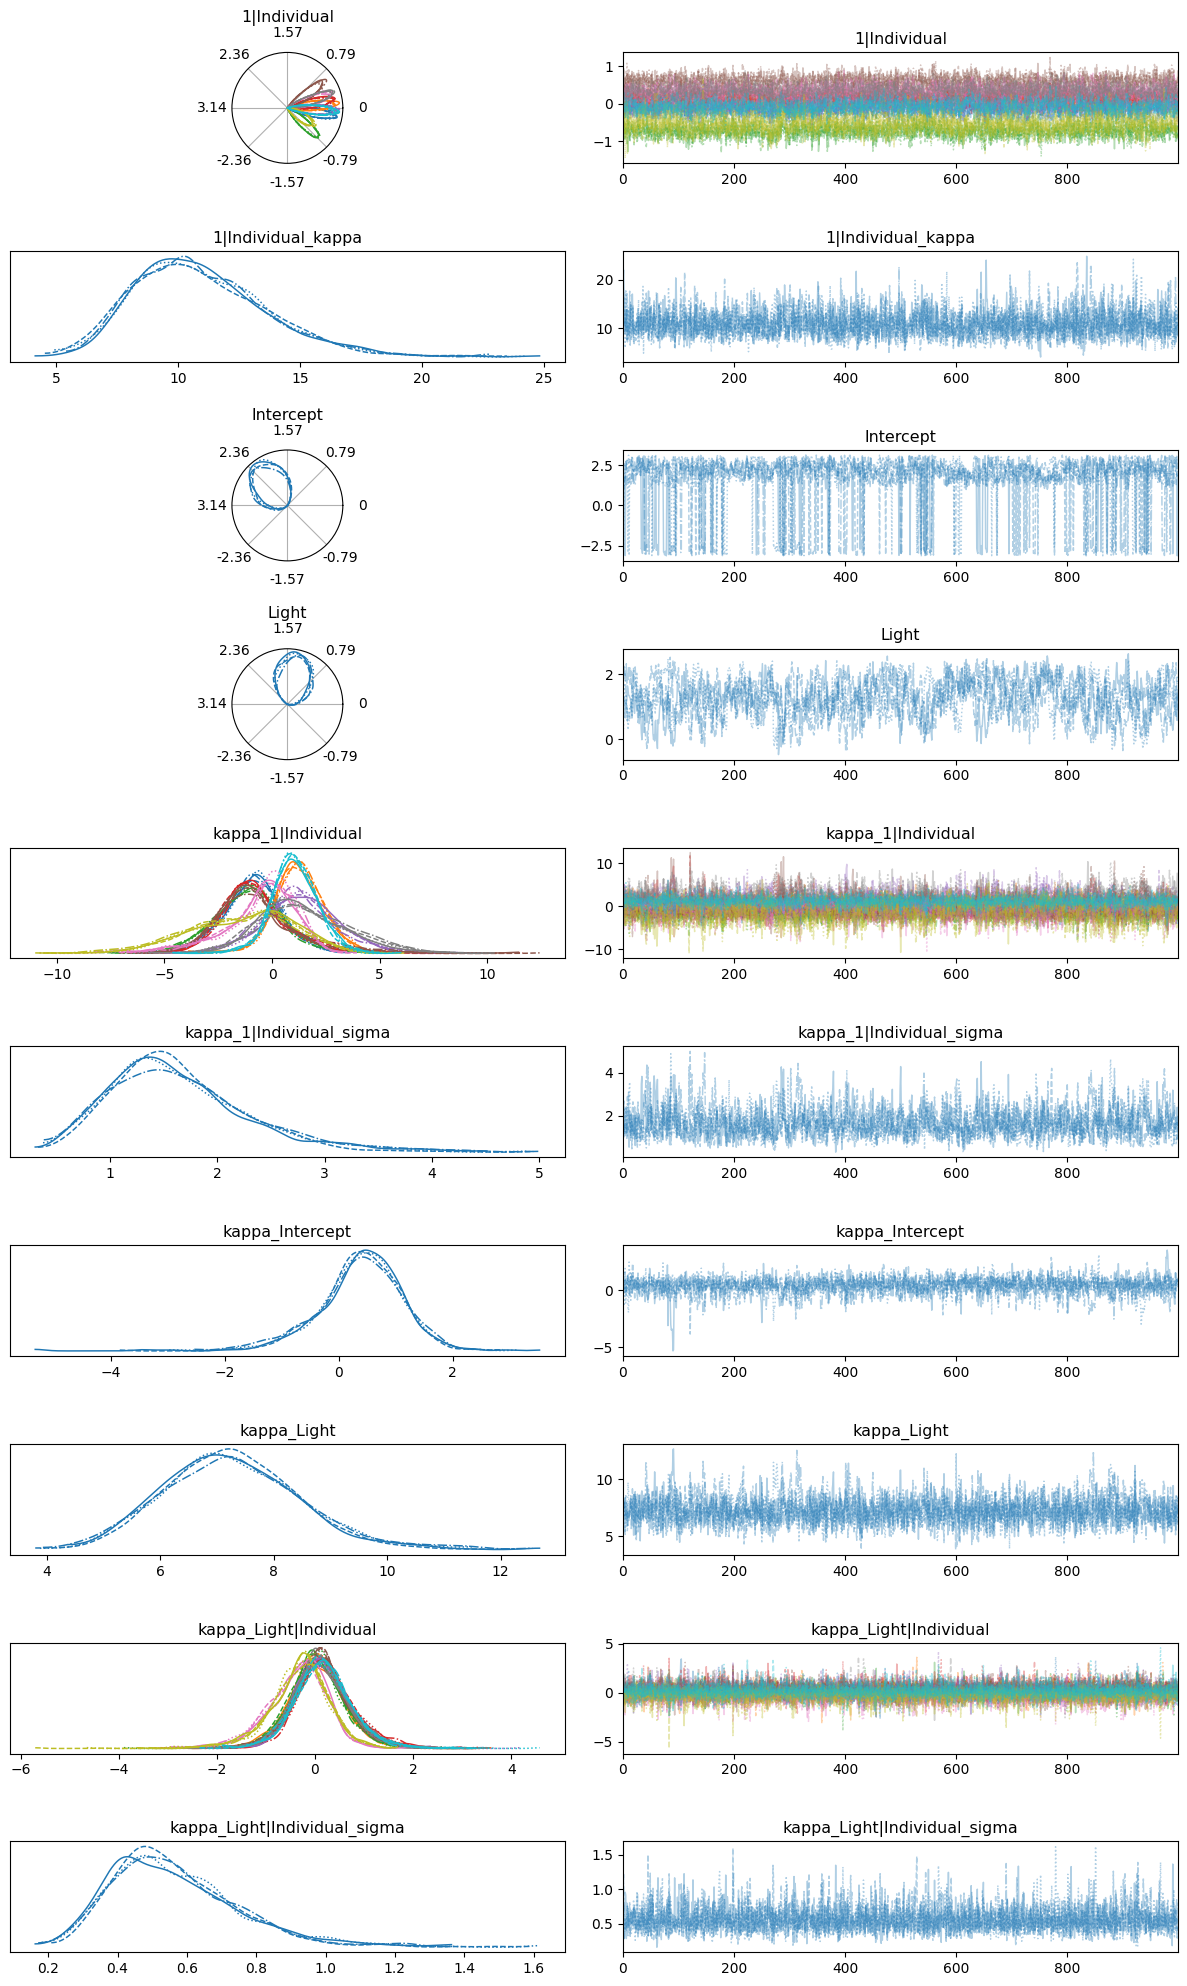

In [17]:
# varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
# for cvar in cvars:
#     idata_wide_trans.posterior[cvar] = -180*idata_wide_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_nolightkm,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()

# Model comparison for hypothesis testing
Initially, just compare the restrictive and loosened prior models


In [18]:
#First the log likelihood function needs to be computed for each model and dataset

# model_tight.compute_log_likelihood(idata_wide)
# # model_wide.compute_log_likelihood(idata_wide)
# import pymc as pm
# pm.compute_log_likelihood(idata_wide, model = model_tight)
# pm.compute_log_likelihood(idata_wide, model = model_wide)



In [19]:
#Calculate predictive power using LOO cross-validation
import pymc as pm
loo_tight = az.loo(idata_wide)
loo_wide = az.loo(idata_wide)
loo_nolightkm = az.loo(idata_nolightkm)
# loo_wide = az.reloo(loo_orig=loo_wide,
#                     wrapper=az.SamplingWrapper(model_wide),
#                     k_thresh = 0.7)

C:\Users\James Foster\AppData\Roaming\Python\Python312\site-packages\arviz\stats\stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [20]:
#print the results
print('\n----- Tight -----\n')
print(loo_tight)
print('\n----- Wide -----\n')
print(loo_wide)
print('\n----- No light kappa_mu -----\n')
print(loo_nolightkm)
#some warnings in a small proportion of cases, but predictions are generally accurate



----- Tight -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -133.10    15.38
p_loo       24.62        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      196  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


----- Wide -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -133.10    15.38
p_loo       24.62        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      196  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%


----- No light kappa_mu -----

Computed from 4000 posterior samples and 196 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -209.90    15.52
p_loo       35.22        -

There has been a warning during the calculation. Please c

In [21]:
#compare, ranking models from best to worst
az.compare({'Tight':loo_tight,
            'Wide':loo_wide,
            'No light': loo_nolightkm
            }, 
            ic="loo")

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
Tight        0 -133.099779  24.624297   0.000000  0.493258  15.377853   
Wide         1 -133.099779  24.624297   0.000000  0.493258  15.377853   
No light     2 -209.897346  35.218839  76.797566  0.013485  15.519588   

                dse  warning scale  
Tight      0.000000    False   log  
Wide       0.000000    False   log  
No light  10.330828     True   log

# Inspect the change in $\kappa_\mu$

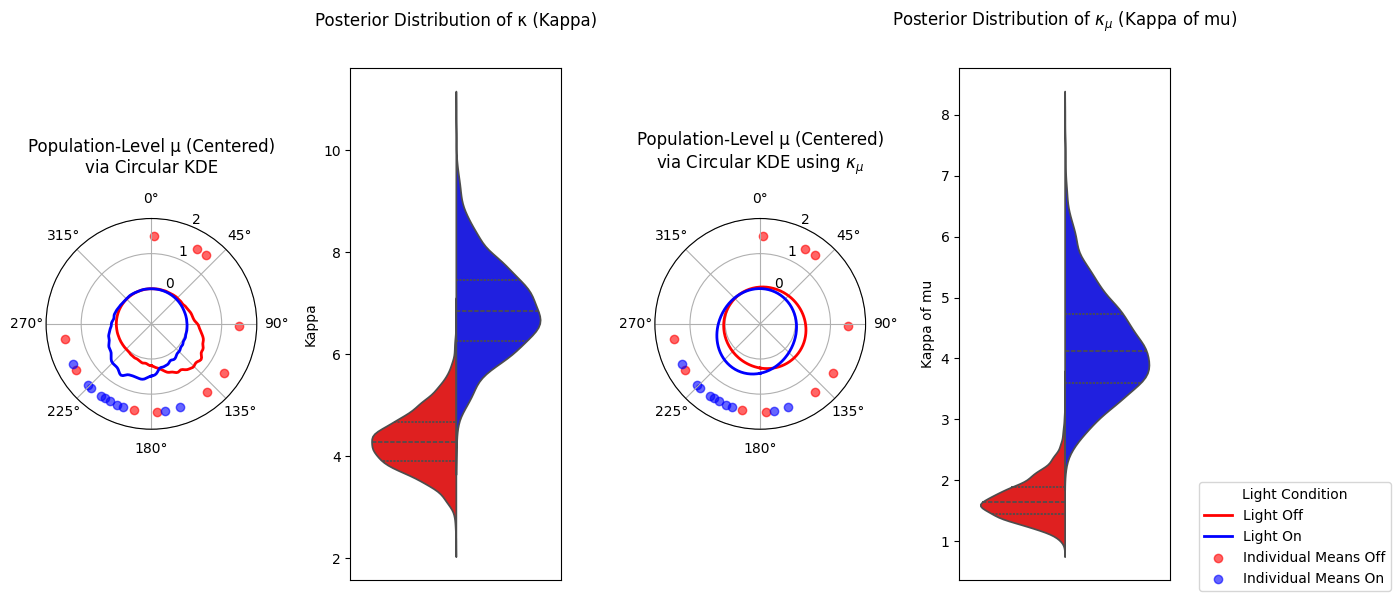

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata_wide.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata_wide.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata_wide.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata_wide.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# For the κ_μ-model:
kappamu_intercept = idata_wide.posterior["1|Individual_kappa"].values    # fixed intercept for κ_μ (linear predictor)
kappamu_slope     = idata_wide.posterior["Light|Individual_kappa"].values        # fixed slope for κ_μ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

# fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())
kappamu_pop_off_samples_all = softplus(kappamu_intercept.flatten())
kappamu_pop_on_samples_all  = softplus((kappamu_intercept + kappamu_slope).flatten())

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_kappamu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=np.median(kappamu_pop_off_samples_all),
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_kappamu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=np.median(kappamu_pop_on_samples_all),
                 loc=mu_on_centered[:, None]),
    axis=0
)


# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# ---------------------------
# Process κ_μ (Kappa of mu) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappamu_off = kappamu_pop_off_samples_all
kappamu_on  = kappamu_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappamu = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappamu_off) + len(kappamu_on)),
    "Light": ["Light Off"] * len(kappamu_off) + ["Light On"] * len(kappamu_on),
    "Value": np.concatenate([kappamu_off, kappamu_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 4, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')

    # Scatter-plot data.
# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax1.scatter(individual_circmean_off, 2.5, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax1.scatter(individual_circmean_on, 2.5, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")
    
ax1.set_title("Population-Level μ (Centered)\nvia Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])

# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 4, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])

# (C) Polar subplot for kappa mu.
ax3 = fig.add_subplot(1, 4, 3, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax3.set_theta_zero_location('N')#place 0° at the top
ax3.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax3.plot(theta, kde_kappamu_off + 1, color='red', lw=2, label='Light Off')
ax3.plot(theta, kde_kappamu_on + 1, color='blue', lw=2, label='Light On')

    # Scatter-plot data.
# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax3.scatter(individual_circmean_off, 2.5, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax3.scatter(individual_circmean_on, 2.5, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")
    
ax3.set_title("Population-Level μ (Centered)\nvia Circular KDE using $κ_μ$", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_kappamu_off), np.max(kde_kappamu_on))
ax3.set_rlim(0, 1 + max_density * 1.5)
ax3.set_rticks([1, 2, 3], [0, 1, 2])


# (D) Cartesian subplot for κ_μ.
ax4 = fig.add_subplot(1, 4, 4)
sns.violinplot(x="Parameter", y="Value", hue="Light",
            data=df_kappamu, split=True, inner="quartile",
            palette={"Light Off": "red", "Light On": "blue"},
            ax=ax4)
ax4.set_title("Posterior Distribution of $κ_μ$ (Kappa of mu)", pad=30)
ax4.set_xlabel("")
ax4.set_ylabel("Kappa of mu")
ax4.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for All Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()
if ax3.get_legend() is not None:
    ax3.get_legend().remove()
if ax4.get_legend() is not None:
    ax4.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="lower right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()